## Install statsbombpy library

In [1]:
pip install statsbombpy


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# 1 Creating The Network/Graph

## Import sb from statsbombpy

In [2]:
from statsbombpy import sb

## 1.1 Determine starting conditions
### This notebook is very general in it's format, fill in the following below and every cell will run without any other modifications needed:
Variables to fill out:
1. match_id

In [3]:
match_id = 18245  # was Real-Madrid vs liverpool in the champions league final 2018-05-26
# match_id = 9924  # was Real-Madrid vs Barcelona in La Liga 2017/2018 (2018-05-06)
# match_id = 9736  # was Real-Madrid vs Barcelona in La Liga 2017/2018 (2017-12-23)
# match_id = 267569  # was Real-Madrid vs Barcelona in La Liga 2016/1017 (2017-04-23)
# match_id = 267076  # was Real-Madrid vs Barcela in La Liga 2016/2017 (2016-12-03)

# match_id = 3754042 # West Brom vs Liverpool (2016-05-15) AWAY
# match_id = 3754055 # Liverpool vs Chelsea (2016-05-11) HOME
# match_id = 3754226 # Sunderland vs Liverpool (2015-12-30) AWAY
# match_id = 3754255 # Liverpool vs West Brom (2015-12-13) HOME
# match_id = 3753984 # Liverpool vs West Ham (2015-08-29) HOME

# match_id = 3879862 # Torino vs Napoli (2016-05-08) AWAY
# match_id = 3879817 # Inter Milan vs Napoli (2016-04-16) AWAY
# match_id = 3879699 # Sampdoria vs Napoli (2016-01-24) AWAY
# match_id = 3879609 # Napoli vs Udinese (2015-11-08) HOME
# match_id = 3879645 # Bologna vs Napoli (2015-12-06) AWAY

## 1.2 Select the event
### ie. select all the data from the match with match id = ...

In [4]:
# Select the match
events=sb.events(match_id=match_id)

# Get the team info
teams = events['team'].unique()
team1 = teams[0]
team2 = teams[1]

print("team 1:" + team1)
print("team 2:" + team2)

team 1:Real Madrid
team 2:Liverpool


## 1.3 Create a list for each teams starting XI

In [5]:
# Getting team 1's starting XI
team1_data = events.loc[events['team'] == team1]
team1_starting_xi_data = team1_data.loc[events['type'] == 'Starting XI']

team1_starting_xi = []
for player in team1_starting_xi_data['tactics'][0]['lineup']:
    team1_starting_xi.append(player['player']['name'])
    
    
# Getting team 2's starting XI
team2_data = events.loc[events['team'] == team2]
team2_starting_xi_data = team2_data.loc[events['type'] == 'Starting XI']

team2_starting_xi = []
for player in team2_starting_xi_data['tactics'][1]['lineup']:
    team2_starting_xi.append(player['player']['name'])

## 1.4 Massage the data (Split the data into two dataframes, one for each team, and only keep relevant columns)
### Relevant columns are:
- location (starting location of pass)
- pass_end_location (ending location of pass)
- team
- player
- pass recipient
- timestamp

In [6]:
all_events_df = events[['location', 'pass_end_location', 'team', 'player', 'pass_recipient', 'timestamp']].dropna()

team1_df = all_events_df.loc[all_events_df['team'] == team1].reset_index(drop=True)
team2_df = all_events_df.loc[all_events_df['team'] == team2].reset_index(drop=True)

## Import pandas so we can work with the dataframe

In [7]:
import pandas as pd

## 1.5 Split location and pass_end location columns into 2 columns each
### These columns being:
- Split location into start_x, start_y
- Split pass_end_location into end_x, end_y

In [8]:
# Splitting columns for team 1
team1_pass_start_df = pd.DataFrame(team1_df['location'].to_list(), columns=['start_x', 'start_y']).reset_index(drop=True)
team1_df_final = team1_df.join(team1_pass_start_df)
team1_pass_end_df = pd.DataFrame(team1_df['pass_end_location'].to_list(), columns=['end_x', 'end_y']).reset_index(drop=True)
team1_df_final = team1_df_final.join(team1_pass_end_df)

# Splitting columns for team 2
team2_pass_start_df = pd.DataFrame(team2_df['location'].to_list(), columns=['start_x', 'start_y']).reset_index(drop=True)
team2_df_final = team2_df.join(team2_pass_start_df)
team2_pass_end_df = pd.DataFrame(team2_df['pass_end_location'].to_list(), columns=['end_x', 'end_y']).reset_index(drop=True)
team2_df_final = team2_df_final.join(team2_pass_end_df)

## 1.6 Massage the dataframes more so we are left with these columns:
- player
- pass_recipient
- start_x
- start_y
- end_x
- end_y

In [9]:
# Dropping irrelevant columns for team 1
team1_df_final = team1_df_final.drop(columns=['location', 'pass_end_location', 'timestamp', 'team'])

# Dropping irrelevant columns for team 2
team2_df_final = team2_df_final.drop(columns=['location', 'pass_end_location', 'timestamp', 'team'])

## 1.7 Drop the rows which don't contain players in the starting XI, we are not interested in data about substitutes

In [10]:
# Only keeping rows which contain players in the starting XI
team1_df_final = team1_df_final[team1_df_final['player'].isin(team1_starting_xi)]
team1_df_final = team1_df_final[team1_df_final['pass_recipient'].isin(team1_starting_xi)]

# Only keeping rows which contain players in the starting XI
team2_df_final = team2_df_final[team2_df_final['player'].isin(team2_starting_xi)]
team2_df_final = team2_df_final[team2_df_final['pass_recipient'].isin(team2_starting_xi)]

## 1.8 Massage the data even more to have average start_x and start_y columns. This the the position on the field (in our graph), these nodes will be placed

### The final dataframes will have these columns:
- player
- start_x (an average of all this players start_x positions)
- start_y (an average of all this players start_y positions)

In [11]:
# Massage data as described above for team 1
team1_average_df = team1_df_final.groupby('player').agg({'start_x': 'mean', 'start_y': 'mean'}).reset_index()

# Massage data as described above for team 2
team2_average_df = team2_df_final.groupby('player').agg({'start_x': 'mean', 'start_y': 'mean'}).reset_index()

## 1.9 Now it's time to make the graphs
### The graph should be created as follows:
- One directed graph for each team
    - Each node represents a player on a team's starting XI
        - Nodes are position according to the players average start_x and start_y position
    - An edge exists between two nodes (players) IF, in the match one played 2 passes to another
        - Add weights to edges: The weight of an edge is the total number of passes a player played to another throughout the match modulo 2

In [12]:
import networkx as nx

# Create graph for team 1
G1 = nx.DiGraph()

# Add nodes with player names and their average starting positions
for index, row in team1_average_df.iterrows():
    G1.add_node(row['player'], x=row['start_x'], y=row['start_y'])
# Creating a map to store the number of passes each player plays to another
team1_player_pass_counts = {}
for player in team1_starting_xi:
    pass_recipients = {}
    for player2 in team1_starting_xi:
        pass_recipients[player2] = 0
    
    team1_player_pass_counts[player] = pass_recipients

# Add edges
for index, row in team1_df_final.iterrows():
    player = row['player']
    pass_recipient = row['pass_recipient']

    # Increament edge wight/add edge for every 2 passes between players
    team1_player_pass_counts[player][pass_recipient] += 1
    if G1.has_edge(player, pass_recipient):
        # Edge already exists, increment the pass count map and weight if needed
        if (team1_player_pass_counts[player][pass_recipient] % 2 == 0):
            G1[player][pass_recipient]['weight'] += 1
    else:
        # Edge doesn't exist, create it with weight 1
        if (team1_player_pass_counts[player][pass_recipient] % 2 == 0):
            G1.add_edge(player, pass_recipient, weight=1)
            

# Create graph for team 2
G2 = nx.DiGraph()

# Add nodes with player names and their average starting positions
for index, row in team2_average_df.iterrows():
    G2.add_node(row['player'], x=row['start_x'], y=row['start_y'])
    
# Creating a map to store the number of passes each player plays to another
team2_player_pass_counts = {}
for player in team2_starting_xi:
    pass_recipients = {}
    for player2 in team2_starting_xi:
        pass_recipients[player2] = 0
    
    team2_player_pass_counts[player] = pass_recipients
    
# Add edges
for index, row in team2_df_final.iterrows():
    player = row['player']
    pass_recipient = row['pass_recipient']

    # Increament edge wight/add edge for every 2 passes between players
    team2_player_pass_counts[player][pass_recipient] += 1
    # Increament edge wight/add edge for every 2 passes between players
    if G2.has_edge(player, pass_recipient):
        # Edge already exists, increment the pass count map and weight if needed
        if (team2_player_pass_counts[player][pass_recipient] % 2 == 0):
            G2[player][pass_recipient]['weight'] += 1
    else:
        # Edge doesn't exist, create it with weight 1
        if (team2_player_pass_counts[player][pass_recipient] % 2 == 0):
            G2.add_edge(player, pass_recipient, weight=1)

## Install todofcpy so that we can create a nice visualization

In [13]:
pip install todofcpy


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 1.10 Time to make the plot. 
### Here is the step by step:
- Create a dictionary with keys for each node (player) and the values being a tuple for their average start_x and average start_y position
- Create a dictionary for the edge labels (weights)
- Create a field from todofcpy.visualization.graph
- Use networkx to draw our graph onto the field

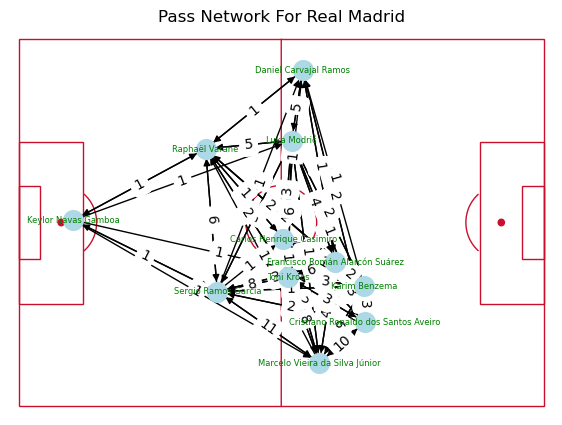

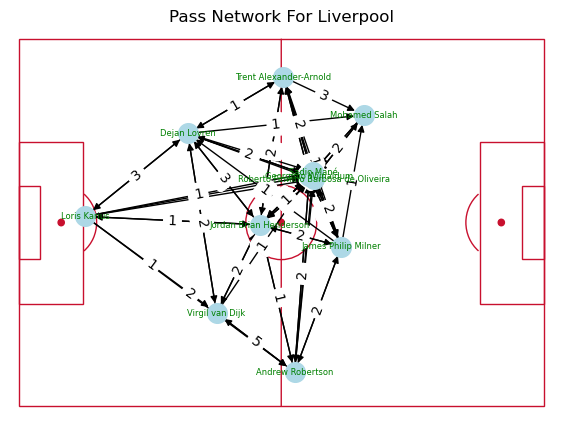

In [14]:
import matplotlib.pyplot as plt
from todofcpy.visualization.graph import Field

# Network visualization for team 1
pos = {player: (team1_average_df.loc[team1_average_df['player'] == player, 'start_x'].values[0], 
                team1_average_df.loc[team1_average_df['player'] == player, 'start_y'].values[0])
                for player in G1.nodes()}
edge_labels = {(u, v): d['weight'] for u, v, d in G1.edges(data=True)}

field = Field()
plt = field.create_field(grass='#FFFFFF', lines = '#C8102E')

nx.draw(G1, pos, with_labels=True, node_size=200, font_size=6, node_color='lightblue', font_color='green')
nx.draw_networkx_edge_labels(G1, pos, edge_labels=edge_labels)
plt.title("Pass Network For " + team1)
plt.show()

# Network visualization for team 2
pos2 = {player: (team2_average_df.loc[team2_average_df['player'] == player, 'start_x'].values[0], 
                team2_average_df.loc[team2_average_df['player'] == player, 'start_y'].values[0])
                for player in G2.nodes()}
edge_labels2 = {(u, v): d['weight'] for u, v, d in G2.edges(data=True)}


field2 = Field()
plt2 = field2.create_field(grass='#FFFFFF', lines = '#C8102E')

nx.draw(G2, pos2, with_labels=True, node_size=200, font_size=6, node_color='lightblue', font_color='green')
nx.draw_networkx_edge_labels(G2, pos2, edge_labels=edge_labels2)
plt2.title("Pass Network For " + team2)
plt2.show()

# 2 Motif Detection

## 2.1
1. Download sageMath from https://github.com/3-manifolds/Sage_macOS/releases
2. Run the sage-math application from the applications folder, and open this notebook from within that application
3. Now we are ready, let's count the occurences of all the size 3 motifs in our network (one team's pass map)

In [15]:
import numpy
from sage.graphs.graph import DiGraph

# Edge lists of all possible motifs of size 3
size_3_motifs = [
    [(1, 0), (1, 2)],
    [(1, 0), (2, 1)],
    [(1, 0), (1, 2), (2, 1)],
    [(1, 0), (2, 0)],
    [(1, 0), (1, 2), (2, 1)],
    [(1, 0), (1, 2), (2, 1), (2, 0)],
    [(0, 1), (1, 2), (2, 1)],
    [(0, 1), (1, 0), (1, 2), (2, 1)],
    [(0, 1), (1, 2), (2, 0)],
    [(0, 1), (1, 0), (1, 2), (2, 0)],
    [(0, 1), (1, 0), (2, 1), (2, 0)],
    [(0, 1), (1, 0), (1, 2), (2, 1), (2, 0)],
    [(0, 1), (1, 0), (1, 2), (2, 1), (2, 0), (0, 2)]
]

# Turning the edge lists into directed graphs
M1 = DiGraph(size_3_motifs[0])
M2 = DiGraph(size_3_motifs[1])
M3 = DiGraph(size_3_motifs[2])
M4 = DiGraph(size_3_motifs[3])
M5 = DiGraph(size_3_motifs[4])
M6 = DiGraph(size_3_motifs[5])
M7 = DiGraph(size_3_motifs[6])
M8 = DiGraph(size_3_motifs[7])
M9 = DiGraph(size_3_motifs[8])
M10 = DiGraph(size_3_motifs[9])
M11 = DiGraph(size_3_motifs[10])
M12 = DiGraph(size_3_motifs[11])
M13 = DiGraph(size_3_motifs[12])

# Adding the motif graphs to a map
motif_map = {'M1': M1,
             'M2': M2,
             'M3': M3,
             'M4': M4,
             'M5': M5,
             'M6': M6,
             'M7': M7,
             'M8': M8,
             'M9': M9,
             'M10': M10,
             'M11': M11,
             'M12': M12,
             'M13': M13}

# Getting the edge list of our network and creating a different type of directed graph so we can
# count subgraph occurrences as networkx cannot do that
######################################################################################################
# CHANGE THE BELOW LINE DEPENDING ON WHICH GRAPH CREATED PREVIOUSLY IS THE TEAM OF INTEREST
G1_edgelist = list(G1.edges)
######################################################################################################
G1_digraph = DiGraph(G1_edgelist)


# Iterating through our network to count the number of occurrences of each motif in our network
for motif, motif_graph in motif_map.items():
    occurrence_list = []
    for subgraph in G1_digraph.subgraph_search_iterator(motif_graph, induced=True):
        occurrence_list.append(subgraph)
        
    print(len(occurrence_list))

0
1
8
0
8
6
17
38
0
4
6
37
354


## 2.2 After some magic, ie running the above for all 5 games and storing the results in excel, we can create a DataFrame with the data
### With this DataFrame, we can represent the data in a plot

In [16]:
pip install openpyxl


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import os

# Load the data collected previsouly into a pandas dataframe
# motif_df = pd.read_excel('Motif Analysis Data/Real Madrid Motif Occurrences (Edge every 2 passes).xlsx')


# Get the absolute path to the script's directory
script_dir = os.getcwd()

# Specify the absolute path to the Excel file
excel_file_path = os.path.join(script_dir, 'Motif Analysis Data', 'Motif Occurrences (Edge every 2 passes).xlsx')

# Read the Excel file
motif_df = pd.read_excel(excel_file_path)

## 2.3 Count the motif occurrences in a random model/graph with the same number of nodes and edges as our real-world network

### USING THE CONFIGURATION MODEL

In [18]:
#####################################################################################################
# CHANGE THE BELOW LINE DEPENDING ON WHICH GRAPH CREATED PREVIOUSLY IS THE TEAM OF INTEREST
G = G1
######################################################################################################

in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())
in_deg_seq = list(in_degree.values())
out_deg_seq = list(out_degree.values())

random_graph = nx.directed_configuration_model(in_deg_seq, out_deg_seq)
random_graph.remove_edges_from(nx.selfloop_edges(random_graph))

# Turn that random graph into the different type so we can iterate through subgraph occurrences in it
random_graph_edges = list(random_graph.edges)
random_graph2 = DiGraph(random_graph_edges)

total_motif_counts = []   # MOTIF COUNTS FOR RANDOM GRAPH

# Iterating through the random graph to count the number of occurrences of each motif
for motif, motif_graph in motif_map.items():
    occurrence_list = []
    for subgraph in random_graph2.subgraph_search_iterator(motif_graph, induced=True):
        occurrence_list.append(subgraph)
    
    total_motif_counts.append(len(occurrence_list))

## 3.4 Create a network significance profile 
- Create a vector of normalized Z-scores to show us how our data compares to that of a random graph (If a motif is over or under-represented in our real world network compared to a random model)

In [19]:
import numpy as np
import math

# Getting the mean and standard deviation of the number of motif occurrences in our random graph
mean_randomized = np.mean(total_motif_counts)
std_dev_randomized = np.std(total_motif_counts)

# Getting the z-scores of the number of motif occurrences in our real-world network
z_scores = []
for count in motif_df[match_id]: 
    z_scores.append((count - mean_randomized) / std_dev_randomized)

# Normalizing the z-scores
normalized_z_scores = []
denominator = math.sqrt(sum(x**2 for x in z_scores))
for z in z_scores:
    normalized_z_scores.append(z/denominator)
    
for i in normalized_z_scores:
    print(i)

-0.05059398132862101
-0.0476577234836564
-0.02710391856890411
-0.05059398132862101
-0.02710391856890411
-0.032976434258833336
-0.0006775979642226004
0.06098381678003426
-0.05059398132862101
-0.03884894994876256
-0.032976434258833336
0.05804755893506964
0.9888412957888517


## 3.5 Like before, I did the above for all 5 games and put the data into excel so it can be imported in. Now, plot the results.

### We conducted 3 iterations of the motif detection algorithm. One of Real Madrid, another for Liverpool, and a thrid for Napoli

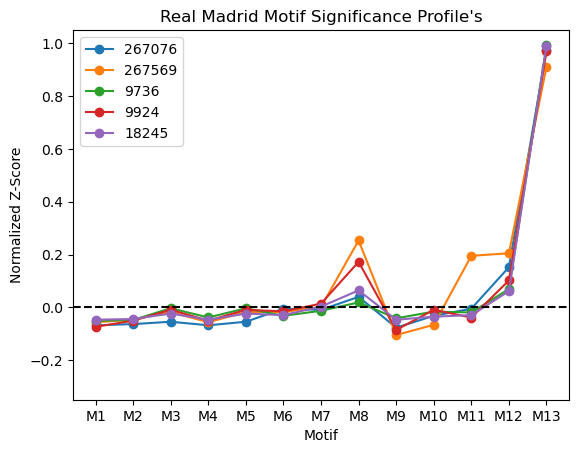

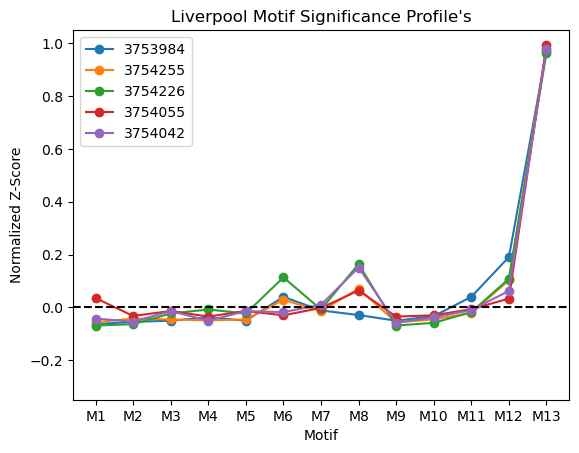

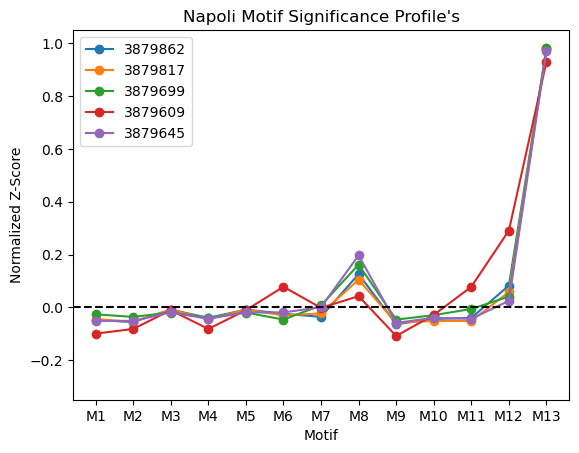

In [20]:
# Real Madrid standardized motif occurrences using configuration model and edge every 2 passes
standardized_motif_z_score_df = pd.read_excel(os.path.join(script_dir, 'Motif Analysis Data', "Motif Standardized Z-Score's (Edge every 2 passes, using configuration model).xlsx"))

plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[267076], label='267076', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[267569], label='267569', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[9736], label='9736', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[9924], label='9924', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[18245], label='18245', marker='o')

plt2.axhline(y=0, color='black', linestyle='--')
plt2.ylim(-0.35, 1.05)


plt2.xlabel('Motif')
plt2.ylabel('Normalized Z-Score')
plt2.title("Real Madrid Motif Significance Profile's")
plt2.legend()

plt2.show()

# Same but for Liverpool games
standardized_motif_z_score_df = pd.read_excel(os.path.join(script_dir, 'Motif Analysis Data', "Liverpool Motif Standardized Z-Score's (Edge every 2 passes, using configuration model).xlsx"))

plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[3753984], label='3753984', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[3754255], label='3754255', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[3754226], label='3754226', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[3754055], label='3754055', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[3754042], label='3754042', marker='o')

plt2.axhline(y=0, color='black', linestyle='--')
plt2.ylim(-0.35, 1.05)


plt2.xlabel('Motif')
plt2.ylabel('Normalized Z-Score')
plt2.title("Liverpool Motif Significance Profile's")
plt2.legend()

plt2.show()

# Same but for Napoli games
standardized_motif_z_score_df = pd.read_excel(os.path.join(script_dir, 'Motif Analysis Data', "Napoli Motif Standardized Z-Score's (Edge every 2 passes, using configuration model).xlsx"))

plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[3879862], label='3879862', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[3879817], label='3879817', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[3879699], label='3879699', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[3879609], label='3879609', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[3879645], label='3879645', marker='o')

plt2.axhline(y=0, color='black', linestyle='--')
plt2.ylim(-0.35, 1.05)


plt2.xlabel('Motif')
plt2.ylabel('Normalized Z-Score')
plt2.title("Napoli Motif Significance Profile's")
plt2.legend()

plt2.show()

# 3 RolX

## 3.1
- https://github.com/benedekrozemberczki/RolX
    - From a link in the above GitHub repository: https://github.com/dkaslovsky/GraphRole

In [21]:
pip install graphrole


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [22]:
from graphrole import RecursiveFeatureExtractor, RoleExtractor

######################################################################################################
# CHANGE THE BELOW LINE DEPENDING ON WHICH GRAPH CREATED PREVIOUSLY IS THE TEAM OF INTEREST
G = G1
positions = pos
edge_labels = edge_labels
# G = nx.compose(G1, G2)
######################################################################################################

feature_extractor = RecursiveFeatureExtractor(G)
features = feature_extractor.extract_features()

print(f'\nFeatures extracted from {feature_extractor.generation_count} recursive generations:')
print(features)


Features extracted from 3 recursive generations:
                                     external_edges(mean)(mean)  \
Carlos Henrique Casimiro                              21.800926   
Cristiano Ronaldo dos Santos Aveiro                   21.918403   
Daniel Carvajal Ramos                                 20.763889   
Francisco Román Alarcón Suárez                        21.918403   
Karim Benzema                                         21.924383   
Keylor Navas Gamboa                                   24.346111   
Luka Modrić                                           21.924383   
Marcelo Vieira da Silva Júnior                        21.893403   
Raphaël Varane                                        21.099653   
Sergio Ramos García                                   20.449722   
Toni Kroos                                            21.893403   

                                     external_edges(mean)  in_degree(mean)  \
Carlos Henrique Casimiro                        15.166667        26

In [23]:
# assign node roles
role_extractor = RoleExtractor(n_roles=None)
role_extractor.extract_role_factors(features)
node_roles = role_extractor.roles

print('\nNode role assignments:')
print(node_roles)

print('\nNode role membership by percentage:')
print(role_extractor.role_percentage.round(2))

  File "/Users/mitchellvomscheidt/.sage/local/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 270, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "/private/var/tmp/sage-10.1-current/local/var/lib/sage/venv-python3.11.1/lib/python3.11/subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/private/var/tmp/sage-10.1-current/local/var/lib/sage/venv-python3.11.1/lib/python3.11/subprocess.py", line 1024, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/private/var/tmp/sage-10.1-current/local/var/lib/sage/venv-python3.11.1/lib/python3.11/subprocess.py", line 1901, in _execute_child
    raise child_exception_type(errno_num, err_msg, err_filename)



Node role assignments:
{'Carlos Henrique Casimiro': 'role_2', 'Cristiano Ronaldo dos Santos Aveiro': 'role_2', 'Daniel Carvajal Ramos': 'role_5', 'Francisco Román Alarcón Suárez': 'role_2', 'Karim Benzema': 'role_2', 'Keylor Navas Gamboa': 'role_5', 'Luka Modrić': 'role_2', 'Marcelo Vieira da Silva Júnior': 'role_4', 'Raphaël Varane': 'role_0', 'Sergio Ramos García': 'role_1', 'Toni Kroos': 'role_1'}

Node role membership by percentage:
                                     role_0  role_1  role_2  role_3  role_4  \
Carlos Henrique Casimiro               0.01    0.01    0.26    0.17    0.09   
Cristiano Ronaldo dos Santos Aveiro    0.08    0.01    0.43    0.23    0.08   
Daniel Carvajal Ramos                  0.11    0.11    0.02    0.11    0.11   
Francisco Román Alarcón Suárez         0.08    0.01    0.43    0.23    0.08   
Karim Benzema                          0.07    0.14    0.74    0.01    0.01   
Keylor Navas Gamboa                    0.01    0.01    0.09    0.18    0.01   
Luka 

In [24]:
pip install seaborn


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [25]:
import seaborn as sns

# build color palette for plotting
unique_roles = sorted(set(node_roles.values()))
color_map = sns.color_palette('Paired', n_colors=len(unique_roles))
# map roles to colors
role_colors = {role: color_map[i] for i, role in enumerate(unique_roles)}
# build list of colors for all nodes in G
node_colors = [role_colors[node_roles[node]] for node in G.nodes]

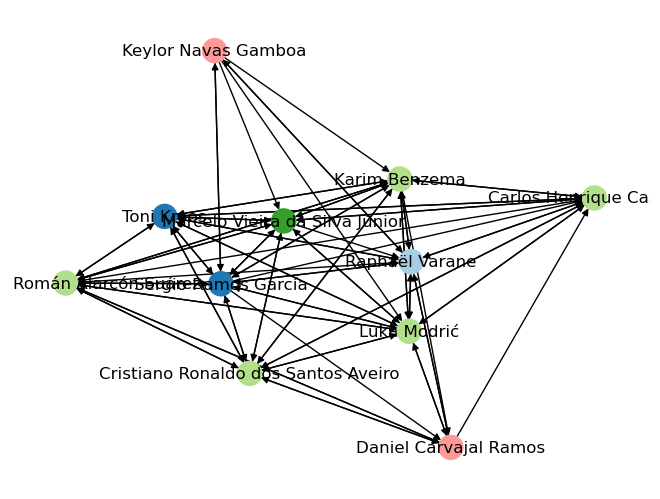

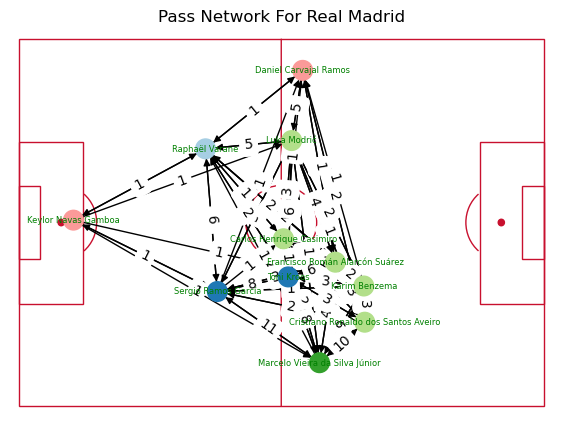

In [26]:
# plot graph
plt.figure()

nx.draw(
    G,
    pos=nx.spring_layout(G, seed=42),
    with_labels=True,
    node_color=node_colors,
)

plt.show()

field2 = Field()
plt2 = field2.create_field(grass='#FFFFFF', lines = '#C8102E')

nx.draw(G, positions, with_labels=True, node_size=200, font_size=6, node_color=node_colors, font_color='green')
nx.draw_networkx_edge_labels(G, positions, edge_labels=edge_labels)
plt2.title("Pass Network For " + team1)
plt2.show()